# Imports

In [164]:
import re
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

pd.options.mode.chained_assignment = None  # default='warn'

# Helper Methods

In [594]:
class DataMerger(BaseEstimator, TransformerMixin):
    def __init__(self, cols_to_keep='all'): self.cols_to_keep = cols_to_keep
    
    def fit(self, web_data_df, github_data_df): return self
    
    def transform(self, web_data_df, github_data_df):
        
        #Cleaning Web Data Df
        cleaned_web_data_df = self.clean_web_df(web_data_df)
        
        #Setting Common Indices
        cleaned_web_data_df = cleaned_web_data_df.set_index(['Z', 'N'])
        github_data_df = github_data_df.set_index(['Z','N'])
        
        #Merging On Indices
        master_df = cleaned_web_data_df.join(github_data_df, how='outer').reset_index()
        
        if self.cols_to_keep == 'all': return master_df
        return master_df[self.cols_to_keep]
    
    #Helper Methods
    def get_percent_uncertainty(self, row):
        if "keV".lower() in str(row["mass"]).lower(): row["Mass Uncertainty (%)"] = np.nan
        else: row["Mass Uncertainty (%)"] = round(float(str(row['mass']).split()[-1]) / row["Mass"] * 100, 4)
        return row
    
    #Cleaner Method
    def clean_web_df(self, data_df):
        
        web_data_df = data_df
        
        #Mass Value Column
        web_data_df["Mass"] = web_data_df['mass'].str.split(' ').str[0].astype(float)
        
        #Half Life Column
        web_data_df.loc[(web_data_df['half-life'] == 'stable'), 'Half Life'] = -1
        web_data_df.loc[(web_data_df['half-life'] == 'unknown'), 'Half Life'] = np.nan
        web_data_df.loc[(web_data_df['half-life'] != 'stable') & 
                (web_data_df['half-life'] != 'unknown'), 
                'Half Life'] = web_data_df['half-life']
        
        
        #Selecting Relevant Columns
        columns_to_keep = ["Z", "Nuclide", "Mass", "Half Life"]
        web_data_df = web_data_df[columns_to_keep]
        
        #Neutron Column
        web_data_df['N'] = np.floor(web_data_df['Mass']) - web_data_df['Z']
        
        return web_data_df

NameError: name 'BaseEstimator' is not defined

In [165]:
def convert_to_seconds(time):

    if(str(time) == '-1.0'): return round(-1)
    if(str(time) == '0'): return 0
    
    measure = re.findall("['AS','MS', 'M','S','Y','H','D','P','U','N']+", time)
    
    if len(measure) == 0: return np.nan
    mes = measure[0]
    value = float(time[:-len(mes)])

    if(mes == 'S'): return value

    if(mes == 'P'): return convert_to_seconds('%sN'%(value/1000))
    if(mes == 'N'): return convert_to_seconds('%sU'%(value/1000))
    if(mes == 'U'): return convert_to_seconds('%sMS'%(value/1000))
    if(mes == 'MS'): return convert_to_seconds('%sS'%(value/1000))

    if(mes == 'M'): return convert_to_seconds('%sS'%(value*60))
    if(mes == 'H'): return convert_to_seconds('%sM'%(value*60))
    if(mes == 'D'): return convert_to_seconds('%sH'%(value*24))
    if(mes == 'Y'): return convert_to_seconds('%sD'%(value*365))
    
    if(mes == 'AS'):
        a = 41341373336493000000
        return convert_to_seconds('%sMS'%(value/a))
    
    return np.nan

In [166]:
def generate_target(half_lives, threshold):
    target = [0] * len(half_lives)
    for i, half_life in enumerate(half_lives):
        if half_life == -1: target[i] = 1 # IF Stable
        elif half_life >= threshold: target[i] = 1 # IF Long Enough Half-Life

    return target

# Loading Data

In [167]:
def load_df():
    web_data_df = pd.read_csv("Data/Loaded_Data/Web_Data.csv")
    keV_index = web_data_df['mass'][web_data_df['mass'].str.contains('keV') == True].index
    web_data_df = web_data_df.drop(keV_index)
    web_data_df.reset_index(drop=True)

    github_data_df = pd.read_csv("Data/Loaded_Data/Github_Data.csv")
    
    
    cols_to_keep = ['Z','N','Half Life'] # Drop M - Energy Mass
    data_merger = DataMerger(cols_to_keep)
    df = data_merger.transform(web_data_df, github_data_df)[1:].reset_index(drop=True)
    df = df.dropna()
    df["Half Life"] = [str(i).split(" ")[0] for i in df["Half Life"]] # Cleaning Half Life

    return df

### Generating Unstable Data

In [168]:
def generate_unstable_data(min_proton, max_proton, min_neutron, max_neutron):
    z, n = [],[]
    for i in range(min_proton,max_proton+1):
        for j in range(min_neutron,max_neutron+1):
            z.append(i)
            n.append(j)

    test_df = pd.DataFrame({'Z':z, 'N':n})
    test_df['Half Life'] = 0

    return test_df

# Adding Features

In [170]:
def add_features(X):
    X['N/P'] = (X['N']/X['Z']).astype(float)
    X['P/N'] = (X['Z']/X['N']).astype(float)
    
    return X

# Splitting Features & Target Vector

In [171]:
def generate_X_y(df, seconds_threshold):
    X = df.drop(['Half Life'], axis=1)
    y = pd.Series(list([convert_to_seconds(i) for i in df['Half Life'].values]))

    X = add_features(X)
    
    y_none_index = [i for i,value in enumerate(y) if y[i] == None]
    X, y = X.drop(y_none_index), y.drop(y_none_index)
    
    X_none_index = [index for index, row in np.isnan(X).iterrows() if row.any()]
    X, y = X.drop(X_none_index), y.drop(X_none_index)
    
    X_inf_index = [index for index, row in np.isinf(X).iterrows() if row.any()]
    X, y = X.drop(X_inf_index), y.drop(X_inf_index)

    target = generate_target(y, seconds_threshold)
    y = pd.Series(target)

    return X.reset_index(drop=True), y.reset_index(drop=True)

# Generating The Model

In [120]:
from keras.models import Sequential
from keras.layers import Dense, Activation

def generate_model(hp):
    model = Sequential()
    input_units = X_train.shape[1]
    model.add(Dense(input_units, input_dim=input_units))

    for i in range(hp.Int("N_Layers", 1, 7)):
        model.add(Dense(hp.Int("Layer {} Units".format(i+1), input_units, input_units*4, input_units//2)))
        model.add(Activation(hp.Choice('Layer {} Activation'.format(i+1), ['relu','tanh','softmax','selu'])))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'msle'])
    
    return model

In [121]:
from keras_tuner.engine.hyperparameters import HyperParameters
from keras_tuner.tuners import RandomSearch

def hypertuned_model(trials, epochs, batch_size):
    tuner = RandomSearch(generate_model, objective="val_msle", 
                     max_trials=trials, executions_per_trial=2, directory=f"{int(time.time())}")

    tuner.search(x=X_train, y=y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

    model = tuner.hypermodel.build(tuner.get_best_hyperparameters()[0])
    return model, tuner

In [181]:
best_tuner = tuner
best_tuner.get_best_hyperparameters()[0].values
### Check if model is working because of hypertuning or epochs

{'N_Layers': 4,
 'Layer 1 Units': 14,
 'Layer 1 Activation': 'relu',
 'Layer 2 Units': 12,
 'Layer 2 Activation': 'selu',
 'Layer 3 Units': 8,
 'Layer 3 Activation': 'selu',
 'Layer 4 Units': 8,
 'Layer 4 Activation': 'relu',
 'Layer 5 Units': 12,
 'Layer 5 Activation': 'relu',
 'Layer 6 Units': 6,
 'Layer 6 Activation': 'tanh',
 'Layer 7 Units': 10,
 'Layer 7 Activation': 'tanh'}

# Putting It All Together

In [197]:
from sklearn.model_selection import train_test_split

custom_unstable1 = generate_unstable_data(20, 60, 150, 170) #Data is for min_half-life
custom_unstable2 = generate_unstable_data(1, 9, 50, 170) #Data is for min_half-life
custom_unstable3 = generate_unstable_data(60, 120, 1, 15) ## Rerun with Changes Values

df = load_df()
df = pd.concat([custom_unstable1, custom_unstable2, custom_unstable3, df]).reset_index(drop=True) # Merge With Custom Unstable

threshold = 3600 #3.154e+7
X, y = generate_X_y(df, threshold)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#model, tuner = hypertuned_model(100, 50, 50)
model = best_tuner.hypermodel.build(best_tuner.get_best_hyperparameters()[0])
model.fit(X_train, y_train, epochs=3000, batch_size=30, verbose=1)

#print(tuner.get_best_hyperparameters()[0].values)

Epoch 1/3000
151/151 [==============================] - 1s 853us/step - loss: 0.5116 - accuracy: 0.8391 - msle: 0.0603
Epoch 2/3000
151/151 [==============================] - 0s 876us/step - loss: 0.3203 - accuracy: 0.8451 - msle: 0.0524
Epoch 3/3000
151/151 [==============================] - 0s 908us/step - loss: 0.2858 - accuracy: 0.8557 - msle: 0.0469
Epoch 4/3000
151/151 [==============================] - 0s 858us/step - loss: 0.2518 - accuracy: 0.8628 - msle: 0.0404
Epoch 5/3000
151/151 [==============================] - 0s 836us/step - loss: 0.2245 - accuracy: 0.8867 - msle: 0.0353
Epoch 6/3000
151/151 [==============================] - 0s 793us/step - loss: 0.1954 - accuracy: 0.9102 - msle: 0.0302
Epoch 7/3000
151/151 [==============================] - 0s 803us/step - loss: 0.1957 - accuracy: 0.9098 - msle: 0.0310
Epoch 8/3000
151/151 [==============================] - 0s 822us/step - loss: 0.1902 - accuracy: 0.9065 - msle: 0.0304
Epoch 9/3000
151/151 [==========================

151/151 [==============================] - 0s 799us/step - loss: 0.1410 - accuracy: 0.9368 - msle: 0.0222
Epoch 70/3000
151/151 [==============================] - 0s 770us/step - loss: 0.1446 - accuracy: 0.9346 - msle: 0.0229
Epoch 71/3000
151/151 [==============================] - 0s 766us/step - loss: 0.1375 - accuracy: 0.9393 - msle: 0.0213
Epoch 72/3000
151/151 [==============================] - 0s 782us/step - loss: 0.1452 - accuracy: 0.9324 - msle: 0.0231
Epoch 73/3000
151/151 [==============================] - 0s 1ms/step - loss: 0.1431 - accuracy: 0.9346 - msle: 0.0225
Epoch 74/3000
151/151 [==============================] - 0s 1ms/step - loss: 0.1374 - accuracy: 0.9395 - msle: 0.0216
Epoch 75/3000
151/151 [==============================] - 0s 941us/step - loss: 0.1384 - accuracy: 0.9362 - msle: 0.0219
Epoch 76/3000
151/151 [==============================] - 0s 946us/step - loss: 0.1397 - accuracy: 0.9375 - msle: 0.0218
Epoch 77/3000
151/151 [==============================] - 0

151/151 [==============================] - 0s 952us/step - loss: 0.1363 - accuracy: 0.9397 - msle: 0.0216
Epoch 138/3000
151/151 [==============================] - 0s 825us/step - loss: 0.1337 - accuracy: 0.9395 - msle: 0.0209
Epoch 139/3000
151/151 [==============================] - 0s 972us/step - loss: 0.1329 - accuracy: 0.9395 - msle: 0.0209
Epoch 140/3000
151/151 [==============================] - 0s 1ms/step - loss: 0.1338 - accuracy: 0.9413 - msle: 0.0209
Epoch 141/3000
151/151 [==============================] - 0s 931us/step - loss: 0.1398 - accuracy: 0.9359 - msle: 0.0222
Epoch 142/3000
151/151 [==============================] - 0s 871us/step - loss: 0.1379 - accuracy: 0.9373 - msle: 0.0219
Epoch 143/3000
151/151 [==============================] - 0s 893us/step - loss: 0.1373 - accuracy: 0.9371 - msle: 0.0218
Epoch 144/3000
151/151 [==============================] - 0s 892us/step - loss: 0.1345 - accuracy: 0.9386 - msle: 0.0214
Epoch 145/3000
151/151 [=========================

151/151 [==============================] - 0s 1ms/step - loss: 0.1357 - accuracy: 0.9364 - msle: 0.0214
Epoch 206/3000
151/151 [==============================] - 0s 1ms/step - loss: 0.1342 - accuracy: 0.9388 - msle: 0.0212
Epoch 207/3000
151/151 [==============================] - 0s 1ms/step - loss: 0.1314 - accuracy: 0.9422 - msle: 0.0208
Epoch 208/3000
151/151 [==============================] - 0s 1ms/step - loss: 0.1312 - accuracy: 0.9413 - msle: 0.0206
Epoch 209/3000
151/151 [==============================] - 0s 1ms/step - loss: 0.1356 - accuracy: 0.9402 - msle: 0.0213
Epoch 210/3000
151/151 [==============================] - 0s 1ms/step - loss: 0.1327 - accuracy: 0.9406 - msle: 0.0210
Epoch 211/3000
151/151 [==============================] - 0s 1ms/step - loss: 0.1333 - accuracy: 0.9426 - msle: 0.0207
Epoch 212/3000
151/151 [==============================] - 0s 1ms/step - loss: 0.1304 - accuracy: 0.9404 - msle: 0.0205
Epoch 213/3000
151/151 [==============================] - 0s 1m

Epoch 273/3000
151/151 [==============================] - 0s 768us/step - loss: 0.1327 - accuracy: 0.9384 - msle: 0.0212
Epoch 274/3000
151/151 [==============================] - 0s 754us/step - loss: 0.1337 - accuracy: 0.9384 - msle: 0.0214
Epoch 275/3000
151/151 [==============================] - 0s 762us/step - loss: 0.1295 - accuracy: 0.9406 - msle: 0.0203
Epoch 276/3000
151/151 [==============================] - 0s 769us/step - loss: 0.1348 - accuracy: 0.9388 - msle: 0.0213
Epoch 277/3000
151/151 [==============================] - 0s 822us/step - loss: 0.1313 - accuracy: 0.9410 - msle: 0.0206
Epoch 278/3000
151/151 [==============================] - 0s 847us/step - loss: 0.1295 - accuracy: 0.9435 - msle: 0.0202
Epoch 279/3000
151/151 [==============================] - 0s 831us/step - loss: 0.1263 - accuracy: 0.9446 - msle: 0.0198
Epoch 280/3000
151/151 [==============================] - 0s 789us/step - loss: 0.1325 - accuracy: 0.9397 - msle: 0.0207
Epoch 281/3000
151/151 [========

151/151 [==============================] - 0s 821us/step - loss: 0.1254 - accuracy: 0.9439 - msle: 0.0196
Epoch 341/3000
151/151 [==============================] - 0s 813us/step - loss: 0.1263 - accuracy: 0.9417 - msle: 0.0200
Epoch 342/3000
151/151 [==============================] - 0s 874us/step - loss: 0.1324 - accuracy: 0.9399 - msle: 0.0211
Epoch 343/3000
151/151 [==============================] - 0s 823us/step - loss: 0.1271 - accuracy: 0.9426 - msle: 0.0201
Epoch 344/3000
151/151 [==============================] - 0s 780us/step - loss: 0.1252 - accuracy: 0.9428 - msle: 0.0199
Epoch 345/3000
151/151 [==============================] - 0s 788us/step - loss: 0.1283 - accuracy: 0.9433 - msle: 0.0202
Epoch 346/3000
151/151 [==============================] - 0s 817us/step - loss: 0.1275 - accuracy: 0.9424 - msle: 0.0201
Epoch 347/3000
151/151 [==============================] - 0s 792us/step - loss: 0.1278 - accuracy: 0.9415 - msle: 0.0201
Epoch 348/3000
151/151 [=======================

151/151 [==============================] - 0s 787us/step - loss: 0.1250 - accuracy: 0.9426 - msle: 0.0196
Epoch 408/3000
151/151 [==============================] - 0s 762us/step - loss: 0.1248 - accuracy: 0.9422 - msle: 0.0197
Epoch 409/3000
151/151 [==============================] - 0s 765us/step - loss: 0.1280 - accuracy: 0.9410 - msle: 0.0203
Epoch 410/3000
151/151 [==============================] - 0s 804us/step - loss: 0.1257 - accuracy: 0.9437 - msle: 0.0194
Epoch 411/3000
151/151 [==============================] - 0s 775us/step - loss: 0.1264 - accuracy: 0.9437 - msle: 0.0199
Epoch 412/3000
151/151 [==============================] - 0s 772us/step - loss: 0.1279 - accuracy: 0.9428 - msle: 0.0200
Epoch 413/3000
151/151 [==============================] - 0s 762us/step - loss: 0.1248 - accuracy: 0.9419 - msle: 0.0196
Epoch 414/3000
151/151 [==============================] - 0s 767us/step - loss: 0.1240 - accuracy: 0.9455 - msle: 0.0193
Epoch 415/3000
151/151 [=======================

151/151 [==============================] - 0s 854us/step - loss: 0.1243 - accuracy: 0.9424 - msle: 0.0196
Epoch 475/3000
151/151 [==============================] - 0s 834us/step - loss: 0.1224 - accuracy: 0.9453 - msle: 0.0191
Epoch 476/3000
151/151 [==============================] - 0s 824us/step - loss: 0.1212 - accuracy: 0.9453 - msle: 0.0188
Epoch 477/3000
151/151 [==============================] - 0s 818us/step - loss: 0.1223 - accuracy: 0.9466 - msle: 0.0190
Epoch 478/3000
151/151 [==============================] - 0s 829us/step - loss: 0.1243 - accuracy: 0.9453 - msle: 0.0196
Epoch 479/3000
151/151 [==============================] - 0s 811us/step - loss: 0.1257 - accuracy: 0.9417 - msle: 0.0197
Epoch 480/3000
151/151 [==============================] - 0s 860us/step - loss: 0.1225 - accuracy: 0.9475 - msle: 0.0191
Epoch 481/3000
151/151 [==============================] - 0s 789us/step - loss: 0.1205 - accuracy: 0.9488 - msle: 0.0187
Epoch 482/3000
151/151 [=======================

151/151 [==============================] - 0s 905us/step - loss: 0.1264 - accuracy: 0.9459 - msle: 0.0197
Epoch 542/3000
151/151 [==============================] - 0s 874us/step - loss: 0.1199 - accuracy: 0.9439 - msle: 0.0188
Epoch 543/3000
151/151 [==============================] - 0s 789us/step - loss: 0.1225 - accuracy: 0.9446 - msle: 0.0193
Epoch 544/3000
151/151 [==============================] - 0s 801us/step - loss: 0.1214 - accuracy: 0.9473 - msle: 0.0186
Epoch 545/3000
151/151 [==============================] - 0s 778us/step - loss: 0.1227 - accuracy: 0.9441 - msle: 0.0193
Epoch 546/3000
151/151 [==============================] - 0s 786us/step - loss: 0.1246 - accuracy: 0.9439 - msle: 0.0195
Epoch 547/3000
151/151 [==============================] - 0s 790us/step - loss: 0.1183 - accuracy: 0.9466 - msle: 0.0184
Epoch 548/3000
151/151 [==============================] - 0s 781us/step - loss: 0.1201 - accuracy: 0.9470 - msle: 0.0186
Epoch 549/3000
151/151 [=======================

151/151 [==============================] - 0s 780us/step - loss: 0.1187 - accuracy: 0.9457 - msle: 0.0182
Epoch 609/3000
151/151 [==============================] - 0s 775us/step - loss: 0.1213 - accuracy: 0.9488 - msle: 0.0191
Epoch 610/3000
151/151 [==============================] - 0s 775us/step - loss: 0.1195 - accuracy: 0.9464 - msle: 0.0187
Epoch 611/3000
151/151 [==============================] - 0s 802us/step - loss: 0.1246 - accuracy: 0.9459 - msle: 0.0196
Epoch 612/3000
151/151 [==============================] - 0s 778us/step - loss: 0.1221 - accuracy: 0.9453 - msle: 0.0192
Epoch 613/3000
151/151 [==============================] - 0s 768us/step - loss: 0.1206 - accuracy: 0.9441 - msle: 0.0189
Epoch 614/3000
151/151 [==============================] - 0s 775us/step - loss: 0.1221 - accuracy: 0.9475 - msle: 0.0192
Epoch 615/3000
151/151 [==============================] - 0s 770us/step - loss: 0.1195 - accuracy: 0.9468 - msle: 0.0187
Epoch 616/3000
151/151 [=======================

151/151 [==============================] - 0s 781us/step - loss: 0.1218 - accuracy: 0.9464 - msle: 0.0191
Epoch 676/3000
151/151 [==============================] - 0s 783us/step - loss: 0.1235 - accuracy: 0.9457 - msle: 0.0192
Epoch 677/3000
151/151 [==============================] - 0s 782us/step - loss: 0.1185 - accuracy: 0.9479 - msle: 0.0183
Epoch 678/3000
151/151 [==============================] - 0s 785us/step - loss: 0.1193 - accuracy: 0.9497 - msle: 0.0185
Epoch 679/3000
151/151 [==============================] - 0s 773us/step - loss: 0.1158 - accuracy: 0.9506 - msle: 0.0178
Epoch 680/3000
151/151 [==============================] - 0s 777us/step - loss: 0.1208 - accuracy: 0.9475 - msle: 0.0187
Epoch 681/3000
151/151 [==============================] - 0s 794us/step - loss: 0.1186 - accuracy: 0.9481 - msle: 0.0185
Epoch 682/3000
151/151 [==============================] - 0s 827us/step - loss: 0.1228 - accuracy: 0.9439 - msle: 0.0194
Epoch 683/3000
151/151 [=======================

151/151 [==============================] - 0s 792us/step - loss: 0.1157 - accuracy: 0.9504 - msle: 0.0180
Epoch 743/3000
151/151 [==============================] - 0s 819us/step - loss: 0.1249 - accuracy: 0.9426 - msle: 0.0196
Epoch 744/3000
151/151 [==============================] - 0s 788us/step - loss: 0.1160 - accuracy: 0.9504 - msle: 0.0181
Epoch 745/3000
151/151 [==============================] - 0s 781us/step - loss: 0.1219 - accuracy: 0.9464 - msle: 0.0190
Epoch 746/3000
151/151 [==============================] - 0s 777us/step - loss: 0.1152 - accuracy: 0.9488 - msle: 0.0180
Epoch 747/3000
151/151 [==============================] - 0s 774us/step - loss: 0.1208 - accuracy: 0.9470 - msle: 0.0189
Epoch 748/3000
151/151 [==============================] - 0s 786us/step - loss: 0.1181 - accuracy: 0.9453 - msle: 0.0186
Epoch 749/3000
151/151 [==============================] - 0s 773us/step - loss: 0.1164 - accuracy: 0.9488 - msle: 0.0184
Epoch 750/3000
151/151 [=======================

151/151 [==============================] - 0s 802us/step - loss: 0.1137 - accuracy: 0.9488 - msle: 0.0178
Epoch 810/3000
151/151 [==============================] - 0s 788us/step - loss: 0.1158 - accuracy: 0.9497 - msle: 0.0180
Epoch 811/3000
151/151 [==============================] - 0s 782us/step - loss: 0.1173 - accuracy: 0.9488 - msle: 0.0182
Epoch 812/3000
151/151 [==============================] - 0s 789us/step - loss: 0.1177 - accuracy: 0.9448 - msle: 0.0184
Epoch 813/3000
151/151 [==============================] - 0s 820us/step - loss: 0.1177 - accuracy: 0.9475 - msle: 0.0184
Epoch 814/3000
151/151 [==============================] - 0s 780us/step - loss: 0.1235 - accuracy: 0.9473 - msle: 0.0194
Epoch 815/3000
151/151 [==============================] - 0s 782us/step - loss: 0.1166 - accuracy: 0.9459 - msle: 0.0183
Epoch 816/3000
151/151 [==============================] - 0s 768us/step - loss: 0.1178 - accuracy: 0.9477 - msle: 0.0186
Epoch 817/3000
151/151 [=======================

151/151 [==============================] - 0s 782us/step - loss: 0.1172 - accuracy: 0.9481 - msle: 0.0183
Epoch 877/3000
151/151 [==============================] - 0s 776us/step - loss: 0.1179 - accuracy: 0.9484 - msle: 0.0184
Epoch 878/3000
151/151 [==============================] - 0s 779us/step - loss: 0.1163 - accuracy: 0.9495 - msle: 0.0182
Epoch 879/3000
151/151 [==============================] - 0s 772us/step - loss: 0.1157 - accuracy: 0.9484 - msle: 0.0181
Epoch 880/3000
151/151 [==============================] - 0s 785us/step - loss: 0.1158 - accuracy: 0.9490 - msle: 0.0180
Epoch 881/3000
151/151 [==============================] - 0s 790us/step - loss: 0.1150 - accuracy: 0.9479 - msle: 0.0181
Epoch 882/3000
151/151 [==============================] - 0s 780us/step - loss: 0.1134 - accuracy: 0.9499 - msle: 0.0177
Epoch 883/3000
151/151 [==============================] - 0s 826us/step - loss: 0.1161 - accuracy: 0.9486 - msle: 0.0181
Epoch 884/3000
151/151 [=======================

151/151 [==============================] - 0s 794us/step - loss: 0.1146 - accuracy: 0.9484 - msle: 0.0179
Epoch 944/3000
151/151 [==============================] - 0s 771us/step - loss: 0.1172 - accuracy: 0.9468 - msle: 0.0185
Epoch 945/3000
151/151 [==============================] - 0s 845us/step - loss: 0.1155 - accuracy: 0.9481 - msle: 0.0181
Epoch 946/3000
151/151 [==============================] - 0s 844us/step - loss: 0.1173 - accuracy: 0.9473 - msle: 0.0182
Epoch 947/3000
151/151 [==============================] - 0s 796us/step - loss: 0.1157 - accuracy: 0.9495 - msle: 0.0182
Epoch 948/3000
151/151 [==============================] - 0s 787us/step - loss: 0.1173 - accuracy: 0.9468 - msle: 0.0184
Epoch 949/3000
151/151 [==============================] - 0s 786us/step - loss: 0.1150 - accuracy: 0.9481 - msle: 0.0179
Epoch 950/3000
151/151 [==============================] - 0s 772us/step - loss: 0.1149 - accuracy: 0.9492 - msle: 0.0178
Epoch 951/3000
151/151 [=======================

151/151 [==============================] - 0s 808us/step - loss: 0.1161 - accuracy: 0.9461 - msle: 0.0182
Epoch 1011/3000
151/151 [==============================] - 0s 785us/step - loss: 0.1182 - accuracy: 0.9486 - msle: 0.0184
Epoch 1012/3000
151/151 [==============================] - 0s 780us/step - loss: 0.1163 - accuracy: 0.9495 - msle: 0.0180
Epoch 1013/3000
151/151 [==============================] - 0s 775us/step - loss: 0.1151 - accuracy: 0.9512 - msle: 0.0178
Epoch 1014/3000
151/151 [==============================] - 0s 794us/step - loss: 0.1135 - accuracy: 0.9515 - msle: 0.0177
Epoch 1015/3000
151/151 [==============================] - 0s 800us/step - loss: 0.1178 - accuracy: 0.9479 - msle: 0.0183
Epoch 1016/3000
151/151 [==============================] - 0s 775us/step - loss: 0.1145 - accuracy: 0.9479 - msle: 0.0178
Epoch 1017/3000
151/151 [==============================] - 0s 775us/step - loss: 0.1142 - accuracy: 0.9497 - msle: 0.0178
Epoch 1018/3000
151/151 [===============

151/151 [==============================] - 0s 790us/step - loss: 0.1196 - accuracy: 0.9484 - msle: 0.0187
Epoch 1078/3000
151/151 [==============================] - 0s 792us/step - loss: 0.1154 - accuracy: 0.9468 - msle: 0.0179
Epoch 1079/3000
151/151 [==============================] - 0s 774us/step - loss: 0.1126 - accuracy: 0.9490 - msle: 0.0174
Epoch 1080/3000
151/151 [==============================] - 0s 778us/step - loss: 0.1130 - accuracy: 0.9479 - msle: 0.0176
Epoch 1081/3000
151/151 [==============================] - 0s 773us/step - loss: 0.1159 - accuracy: 0.9455 - msle: 0.0181
Epoch 1082/3000
151/151 [==============================] - 0s 774us/step - loss: 0.1136 - accuracy: 0.9523 - msle: 0.0177
Epoch 1083/3000
151/151 [==============================] - 0s 799us/step - loss: 0.1133 - accuracy: 0.9484 - msle: 0.0175
Epoch 1084/3000
151/151 [==============================] - 0s 808us/step - loss: 0.1136 - accuracy: 0.9499 - msle: 0.0178
Epoch 1085/3000
151/151 [===============

151/151 [==============================] - 0s 801us/step - loss: 0.1145 - accuracy: 0.9473 - msle: 0.0181
Epoch 1145/3000
151/151 [==============================] - 0s 803us/step - loss: 0.1142 - accuracy: 0.9486 - msle: 0.0178
Epoch 1146/3000
151/151 [==============================] - 0s 805us/step - loss: 0.1163 - accuracy: 0.9481 - msle: 0.0180
Epoch 1147/3000
151/151 [==============================] - 0s 783us/step - loss: 0.1170 - accuracy: 0.9453 - msle: 0.0183
Epoch 1148/3000
151/151 [==============================] - 0s 777us/step - loss: 0.1138 - accuracy: 0.9484 - msle: 0.0177
Epoch 1149/3000
151/151 [==============================] - 0s 776us/step - loss: 0.1196 - accuracy: 0.9446 - msle: 0.0188
Epoch 1150/3000
151/151 [==============================] - 0s 776us/step - loss: 0.1155 - accuracy: 0.9459 - msle: 0.0183
Epoch 1151/3000
151/151 [==============================] - 0s 779us/step - loss: 0.1128 - accuracy: 0.9521 - msle: 0.0176
Epoch 1152/3000
151/151 [===============

151/151 [==============================] - 0s 787us/step - loss: 0.1180 - accuracy: 0.9475 - msle: 0.0185
Epoch 1212/3000
151/151 [==============================] - 0s 783us/step - loss: 0.1168 - accuracy: 0.9453 - msle: 0.0184
Epoch 1213/3000
151/151 [==============================] - 0s 776us/step - loss: 0.1151 - accuracy: 0.9481 - msle: 0.0180
Epoch 1214/3000
151/151 [==============================] - 0s 775us/step - loss: 0.1152 - accuracy: 0.9473 - msle: 0.0180
Epoch 1215/3000
151/151 [==============================] - 0s 902us/step - loss: 0.1154 - accuracy: 0.9473 - msle: 0.0180
Epoch 1216/3000
151/151 [==============================] - 0s 837us/step - loss: 0.1145 - accuracy: 0.9473 - msle: 0.0179
Epoch 1217/3000
151/151 [==============================] - 0s 825us/step - loss: 0.1113 - accuracy: 0.9499 - msle: 0.0174
Epoch 1218/3000
151/151 [==============================] - 0s 1ms/step - loss: 0.1206 - accuracy: 0.9453 - msle: 0.0189
Epoch 1219/3000
151/151 [=================

151/151 [==============================] - 0s 801us/step - loss: 0.1118 - accuracy: 0.9512 - msle: 0.0175
Epoch 1279/3000
151/151 [==============================] - 0s 756us/step - loss: 0.1119 - accuracy: 0.9495 - msle: 0.0175
Epoch 1280/3000
151/151 [==============================] - 0s 760us/step - loss: 0.1134 - accuracy: 0.9488 - msle: 0.0178
Epoch 1281/3000
151/151 [==============================] - 0s 795us/step - loss: 0.1142 - accuracy: 0.9490 - msle: 0.0177
Epoch 1282/3000
151/151 [==============================] - 0s 767us/step - loss: 0.1189 - accuracy: 0.9459 - msle: 0.0186
Epoch 1283/3000
151/151 [==============================] - 0s 764us/step - loss: 0.1144 - accuracy: 0.9477 - msle: 0.0179
Epoch 1284/3000
151/151 [==============================] - 0s 764us/step - loss: 0.1143 - accuracy: 0.9486 - msle: 0.0179
Epoch 1285/3000
151/151 [==============================] - 0s 762us/step - loss: 0.1127 - accuracy: 0.9508 - msle: 0.0176
Epoch 1286/3000
151/151 [===============

151/151 [==============================] - 0s 787us/step - loss: 0.1117 - accuracy: 0.9519 - msle: 0.0172
Epoch 1346/3000
151/151 [==============================] - 0s 779us/step - loss: 0.1146 - accuracy: 0.9510 - msle: 0.0177
Epoch 1347/3000
151/151 [==============================] - 0s 781us/step - loss: 0.1111 - accuracy: 0.9501 - msle: 0.0174
Epoch 1348/3000
151/151 [==============================] - 0s 821us/step - loss: 0.1111 - accuracy: 0.9492 - msle: 0.0175
Epoch 1349/3000
151/151 [==============================] - 0s 783us/step - loss: 0.1109 - accuracy: 0.9492 - msle: 0.0174
Epoch 1350/3000
151/151 [==============================] - 0s 777us/step - loss: 0.1146 - accuracy: 0.9501 - msle: 0.0177
Epoch 1351/3000
151/151 [==============================] - 0s 782us/step - loss: 0.1120 - accuracy: 0.9501 - msle: 0.0176
Epoch 1352/3000
151/151 [==============================] - 0s 778us/step - loss: 0.1177 - accuracy: 0.9475 - msle: 0.0182
Epoch 1353/3000
151/151 [===============

151/151 [==============================] - 0s 793us/step - loss: 0.1113 - accuracy: 0.9515 - msle: 0.0171
Epoch 1413/3000
151/151 [==============================] - 0s 788us/step - loss: 0.1133 - accuracy: 0.9495 - msle: 0.0175
Epoch 1414/3000
151/151 [==============================] - 0s 785us/step - loss: 0.1134 - accuracy: 0.9497 - msle: 0.0178
Epoch 1415/3000
151/151 [==============================] - 0s 810us/step - loss: 0.1153 - accuracy: 0.9504 - msle: 0.0177
Epoch 1416/3000
151/151 [==============================] - 0s 797us/step - loss: 0.1168 - accuracy: 0.9466 - msle: 0.0184
Epoch 1417/3000
151/151 [==============================] - 0s 824us/step - loss: 0.1122 - accuracy: 0.9488 - msle: 0.0176
Epoch 1418/3000
151/151 [==============================] - 0s 776us/step - loss: 0.1119 - accuracy: 0.9490 - msle: 0.0175
Epoch 1419/3000
151/151 [==============================] - 0s 786us/step - loss: 0.1132 - accuracy: 0.9495 - msle: 0.0176
Epoch 1420/3000
151/151 [===============

151/151 [==============================] - 0s 766us/step - loss: 0.1132 - accuracy: 0.9495 - msle: 0.0176
Epoch 1480/3000
151/151 [==============================] - 0s 763us/step - loss: 0.1124 - accuracy: 0.9488 - msle: 0.0177
Epoch 1481/3000
151/151 [==============================] - 0s 766us/step - loss: 0.1126 - accuracy: 0.9512 - msle: 0.0175
Epoch 1482/3000
151/151 [==============================] - 0s 797us/step - loss: 0.1140 - accuracy: 0.9512 - msle: 0.0178
Epoch 1483/3000
151/151 [==============================] - 0s 759us/step - loss: 0.1137 - accuracy: 0.9477 - msle: 0.0179
Epoch 1484/3000
151/151 [==============================] - 0s 765us/step - loss: 0.1154 - accuracy: 0.9459 - msle: 0.0180
Epoch 1485/3000
151/151 [==============================] - 0s 770us/step - loss: 0.1127 - accuracy: 0.9508 - msle: 0.0176
Epoch 1486/3000
151/151 [==============================] - 0s 787us/step - loss: 0.1128 - accuracy: 0.9484 - msle: 0.0176
Epoch 1487/3000
151/151 [===============

151/151 [==============================] - 0s 799us/step - loss: 0.1146 - accuracy: 0.9477 - msle: 0.0181
Epoch 1547/3000
151/151 [==============================] - 0s 827us/step - loss: 0.1131 - accuracy: 0.9492 - msle: 0.0176
Epoch 1548/3000
151/151 [==============================] - 0s 795us/step - loss: 0.1167 - accuracy: 0.9468 - msle: 0.0180
Epoch 1549/3000
151/151 [==============================] - 0s 789us/step - loss: 0.1113 - accuracy: 0.9499 - msle: 0.0174
Epoch 1550/3000
151/151 [==============================] - 0s 787us/step - loss: 0.1126 - accuracy: 0.9479 - msle: 0.0177
Epoch 1551/3000
151/151 [==============================] - 0s 791us/step - loss: 0.1145 - accuracy: 0.9492 - msle: 0.0178
Epoch 1552/3000
151/151 [==============================] - 0s 788us/step - loss: 0.1123 - accuracy: 0.9490 - msle: 0.0175
Epoch 1553/3000
151/151 [==============================] - 0s 790us/step - loss: 0.1125 - accuracy: 0.9490 - msle: 0.0176
Epoch 1554/3000
151/151 [===============

151/151 [==============================] - 0s 807us/step - loss: 0.1120 - accuracy: 0.9495 - msle: 0.0174
Epoch 1614/3000
151/151 [==============================] - 0s 906us/step - loss: 0.1130 - accuracy: 0.9497 - msle: 0.0177
Epoch 1615/3000
151/151 [==============================] - 0s 778us/step - loss: 0.1116 - accuracy: 0.9490 - msle: 0.0175
Epoch 1616/3000
151/151 [==============================] - 0s 770us/step - loss: 0.1117 - accuracy: 0.9495 - msle: 0.0174
Epoch 1617/3000
151/151 [==============================] - 0s 801us/step - loss: 0.1079 - accuracy: 0.9519 - msle: 0.0169
Epoch 1618/3000
151/151 [==============================] - 0s 792us/step - loss: 0.1138 - accuracy: 0.9510 - msle: 0.0176
Epoch 1619/3000
151/151 [==============================] - 0s 790us/step - loss: 0.1145 - accuracy: 0.9497 - msle: 0.0179
Epoch 1620/3000
151/151 [==============================] - 0s 776us/step - loss: 0.1160 - accuracy: 0.9441 - msle: 0.0185
Epoch 1621/3000
151/151 [===============

151/151 [==============================] - 0s 823us/step - loss: 0.1120 - accuracy: 0.9488 - msle: 0.0174
Epoch 1681/3000
151/151 [==============================] - 0s 785us/step - loss: 0.1119 - accuracy: 0.9499 - msle: 0.0175
Epoch 1682/3000
151/151 [==============================] - 0s 781us/step - loss: 0.1129 - accuracy: 0.9508 - msle: 0.0178
Epoch 1683/3000
151/151 [==============================] - 0s 771us/step - loss: 0.1095 - accuracy: 0.9512 - msle: 0.0171
Epoch 1684/3000
151/151 [==============================] - 0s 782us/step - loss: 0.1122 - accuracy: 0.9490 - msle: 0.0177
Epoch 1685/3000
151/151 [==============================] - 0s 768us/step - loss: 0.1128 - accuracy: 0.9501 - msle: 0.0175
Epoch 1686/3000
151/151 [==============================] - 0s 779us/step - loss: 0.1127 - accuracy: 0.9501 - msle: 0.0175
Epoch 1687/3000
151/151 [==============================] - 0s 775us/step - loss: 0.1111 - accuracy: 0.9508 - msle: 0.0173
Epoch 1688/3000
151/151 [===============

151/151 [==============================] - 0s 796us/step - loss: 0.1129 - accuracy: 0.9506 - msle: 0.0174
Epoch 1748/3000
151/151 [==============================] - 0s 774us/step - loss: 0.1135 - accuracy: 0.9490 - msle: 0.0176
Epoch 1749/3000
151/151 [==============================] - 0s 809us/step - loss: 0.1114 - accuracy: 0.9501 - msle: 0.0175
Epoch 1750/3000
151/151 [==============================] - 0s 776us/step - loss: 0.1105 - accuracy: 0.9479 - msle: 0.0174
Epoch 1751/3000
151/151 [==============================] - 0s 787us/step - loss: 0.1137 - accuracy: 0.9486 - msle: 0.0178
Epoch 1752/3000
151/151 [==============================] - 0s 777us/step - loss: 0.1121 - accuracy: 0.9532 - msle: 0.0174
Epoch 1753/3000
151/151 [==============================] - 0s 776us/step - loss: 0.1137 - accuracy: 0.9508 - msle: 0.0178
Epoch 1754/3000
151/151 [==============================] - 0s 800us/step - loss: 0.1096 - accuracy: 0.9490 - msle: 0.0171
Epoch 1755/3000
151/151 [===============

151/151 [==============================] - 0s 778us/step - loss: 0.1151 - accuracy: 0.9477 - msle: 0.0181
Epoch 1815/3000
151/151 [==============================] - 0s 770us/step - loss: 0.1107 - accuracy: 0.9519 - msle: 0.0172
Epoch 1816/3000
151/151 [==============================] - 0s 775us/step - loss: 0.1121 - accuracy: 0.9495 - msle: 0.0176
Epoch 1817/3000
151/151 [==============================] - 0s 816us/step - loss: 0.1097 - accuracy: 0.9521 - msle: 0.0170
Epoch 1818/3000
151/151 [==============================] - 0s 781us/step - loss: 0.1119 - accuracy: 0.9495 - msle: 0.0174
Epoch 1819/3000
151/151 [==============================] - 0s 769us/step - loss: 0.1128 - accuracy: 0.9510 - msle: 0.0176
Epoch 1820/3000
151/151 [==============================] - 0s 767us/step - loss: 0.1114 - accuracy: 0.9490 - msle: 0.0172
Epoch 1821/3000
151/151 [==============================] - 0s 773us/step - loss: 0.1139 - accuracy: 0.9468 - msle: 0.0178
Epoch 1822/3000
151/151 [===============

151/151 [==============================] - 0s 803us/step - loss: 0.1141 - accuracy: 0.9506 - msle: 0.0179
Epoch 1882/3000
151/151 [==============================] - 0s 786us/step - loss: 0.1120 - accuracy: 0.9499 - msle: 0.0175
Epoch 1883/3000
151/151 [==============================] - 0s 996us/step - loss: 0.1140 - accuracy: 0.9508 - msle: 0.0176
Epoch 1884/3000
151/151 [==============================] - 0s 1ms/step - loss: 0.1114 - accuracy: 0.9499 - msle: 0.0173
Epoch 1885/3000
151/151 [==============================] - 0s 880us/step - loss: 0.1109 - accuracy: 0.9515 - msle: 0.0172
Epoch 1886/3000
151/151 [==============================] - 0s 872us/step - loss: 0.1098 - accuracy: 0.9526 - msle: 0.0172
Epoch 1887/3000
151/151 [==============================] - 0s 871us/step - loss: 0.1094 - accuracy: 0.9499 - msle: 0.0169
Epoch 1888/3000
151/151 [==============================] - 0s 775us/step - loss: 0.1133 - accuracy: 0.9504 - msle: 0.0176
Epoch 1889/3000
151/151 [=================

151/151 [==============================] - 0s 830us/step - loss: 0.1092 - accuracy: 0.9479 - msle: 0.0170
Epoch 1949/3000
151/151 [==============================] - 0s 778us/step - loss: 0.1092 - accuracy: 0.9526 - msle: 0.0169
Epoch 1950/3000
151/151 [==============================] - 0s 783us/step - loss: 0.1193 - accuracy: 0.9446 - msle: 0.0188
Epoch 1951/3000
151/151 [==============================] - 0s 783us/step - loss: 0.1088 - accuracy: 0.9506 - msle: 0.0169
Epoch 1952/3000
151/151 [==============================] - 0s 781us/step - loss: 0.1106 - accuracy: 0.9506 - msle: 0.0173
Epoch 1953/3000
151/151 [==============================] - 0s 778us/step - loss: 0.1094 - accuracy: 0.9497 - msle: 0.0170
Epoch 1954/3000
151/151 [==============================] - 0s 785us/step - loss: 0.1116 - accuracy: 0.9492 - msle: 0.0176
Epoch 1955/3000
151/151 [==============================] - 0s 796us/step - loss: 0.1127 - accuracy: 0.9488 - msle: 0.0177
Epoch 1956/3000
151/151 [===============

151/151 [==============================] - 0s 829us/step - loss: 0.1125 - accuracy: 0.9497 - msle: 0.0176
Epoch 2016/3000
151/151 [==============================] - 0s 779us/step - loss: 0.1094 - accuracy: 0.9519 - msle: 0.0172
Epoch 2017/3000
151/151 [==============================] - 0s 776us/step - loss: 0.1138 - accuracy: 0.9497 - msle: 0.0178
Epoch 2018/3000
151/151 [==============================] - 0s 838us/step - loss: 0.1103 - accuracy: 0.9510 - msle: 0.0173
Epoch 2019/3000
151/151 [==============================] - 0s 782us/step - loss: 0.1106 - accuracy: 0.9495 - msle: 0.0172
Epoch 2020/3000
151/151 [==============================] - 0s 771us/step - loss: 0.1099 - accuracy: 0.9526 - msle: 0.0169
Epoch 2021/3000
151/151 [==============================] - 0s 781us/step - loss: 0.1114 - accuracy: 0.9508 - msle: 0.0171
Epoch 2022/3000
151/151 [==============================] - 0s 776us/step - loss: 0.1097 - accuracy: 0.9519 - msle: 0.0171
Epoch 2023/3000
151/151 [===============

151/151 [==============================] - 0s 791us/step - loss: 0.1111 - accuracy: 0.9512 - msle: 0.0173
Epoch 2083/3000
151/151 [==============================] - 0s 780us/step - loss: 0.1075 - accuracy: 0.9532 - msle: 0.0168
Epoch 2084/3000
151/151 [==============================] - 0s 774us/step - loss: 0.1090 - accuracy: 0.9504 - msle: 0.0170
Epoch 2085/3000
151/151 [==============================] - 0s 784us/step - loss: 0.1156 - accuracy: 0.9495 - msle: 0.0180
Epoch 2086/3000
151/151 [==============================] - 0s 778us/step - loss: 0.1119 - accuracy: 0.9492 - msle: 0.0175
Epoch 2087/3000
151/151 [==============================] - 0s 782us/step - loss: 0.1135 - accuracy: 0.9464 - msle: 0.0179
Epoch 2088/3000
151/151 [==============================] - 0s 825us/step - loss: 0.1090 - accuracy: 0.9515 - msle: 0.0169
Epoch 2089/3000
151/151 [==============================] - 0s 787us/step - loss: 0.1132 - accuracy: 0.9495 - msle: 0.0178
Epoch 2090/3000
151/151 [===============

151/151 [==============================] - 0s 818us/step - loss: 0.1084 - accuracy: 0.9528 - msle: 0.0169
Epoch 2150/3000
151/151 [==============================] - 0s 763us/step - loss: 0.1085 - accuracy: 0.9515 - msle: 0.0169
Epoch 2151/3000
151/151 [==============================] - 0s 764us/step - loss: 0.1088 - accuracy: 0.9537 - msle: 0.0167
Epoch 2152/3000
151/151 [==============================] - 0s 764us/step - loss: 0.1104 - accuracy: 0.9506 - msle: 0.0175
Epoch 2153/3000
151/151 [==============================] - 0s 769us/step - loss: 0.1110 - accuracy: 0.9508 - msle: 0.0175
Epoch 2154/3000
151/151 [==============================] - 0s 758us/step - loss: 0.1097 - accuracy: 0.9497 - msle: 0.0171
Epoch 2155/3000
151/151 [==============================] - 0s 776us/step - loss: 0.1136 - accuracy: 0.9484 - msle: 0.0179
Epoch 2156/3000
151/151 [==============================] - 0s 773us/step - loss: 0.1097 - accuracy: 0.9512 - msle: 0.0171
Epoch 2157/3000
151/151 [===============

151/151 [==============================] - 0s 792us/step - loss: 0.1085 - accuracy: 0.9495 - msle: 0.0171
Epoch 2217/3000
151/151 [==============================] - 0s 778us/step - loss: 0.1174 - accuracy: 0.9459 - msle: 0.0184
Epoch 2218/3000
151/151 [==============================] - 0s 825us/step - loss: 0.1056 - accuracy: 0.9550 - msle: 0.0164
Epoch 2219/3000
151/151 [==============================] - 0s 786us/step - loss: 0.1078 - accuracy: 0.9510 - msle: 0.0170
Epoch 2220/3000
151/151 [==============================] - 0s 787us/step - loss: 0.1131 - accuracy: 0.9492 - msle: 0.0176
Epoch 2221/3000
151/151 [==============================] - 0s 785us/step - loss: 0.1088 - accuracy: 0.9492 - msle: 0.0169
Epoch 2222/3000
151/151 [==============================] - 0s 779us/step - loss: 0.1129 - accuracy: 0.9504 - msle: 0.0175
Epoch 2223/3000
151/151 [==============================] - 0s 782us/step - loss: 0.1193 - accuracy: 0.9484 - msle: 0.0185
Epoch 2224/3000
151/151 [===============

151/151 [==============================] - 0s 822us/step - loss: 0.1078 - accuracy: 0.9521 - msle: 0.0168
Epoch 2284/3000
151/151 [==============================] - 0s 779us/step - loss: 0.1075 - accuracy: 0.9508 - msle: 0.0168
Epoch 2285/3000
151/151 [==============================] - 0s 787us/step - loss: 0.1086 - accuracy: 0.9523 - msle: 0.0167
Epoch 2286/3000
151/151 [==============================] - 0s 790us/step - loss: 0.1084 - accuracy: 0.9523 - msle: 0.0168
Epoch 2287/3000
151/151 [==============================] - 0s 1ms/step - loss: 0.1060 - accuracy: 0.9539 - msle: 0.0163
Epoch 2288/3000
151/151 [==============================] - 0s 981us/step - loss: 0.1101 - accuracy: 0.9519 - msle: 0.0171
Epoch 2289/3000
151/151 [==============================] - 0s 861us/step - loss: 0.1090 - accuracy: 0.9510 - msle: 0.0170
Epoch 2290/3000
151/151 [==============================] - 0s 841us/step - loss: 0.1058 - accuracy: 0.9532 - msle: 0.0164
Epoch 2291/3000
151/151 [=================

151/151 [==============================] - 0s 804us/step - loss: 0.1083 - accuracy: 0.9537 - msle: 0.0168
Epoch 2351/3000
151/151 [==============================] - 0s 777us/step - loss: 0.1078 - accuracy: 0.9541 - msle: 0.0165
Epoch 2352/3000
151/151 [==============================] - 0s 782us/step - loss: 0.1080 - accuracy: 0.9552 - msle: 0.0166
Epoch 2353/3000
151/151 [==============================] - 0s 780us/step - loss: 0.1110 - accuracy: 0.9512 - msle: 0.0173
Epoch 2354/3000
151/151 [==============================] - 0s 774us/step - loss: 0.1105 - accuracy: 0.9508 - msle: 0.0172
Epoch 2355/3000
151/151 [==============================] - 0s 783us/step - loss: 0.1089 - accuracy: 0.9515 - msle: 0.0170
Epoch 2356/3000
151/151 [==============================] - 0s 789us/step - loss: 0.1056 - accuracy: 0.9550 - msle: 0.0164
Epoch 2357/3000
151/151 [==============================] - 0s 841us/step - loss: 0.1086 - accuracy: 0.9517 - msle: 0.0168
Epoch 2358/3000
151/151 [===============

151/151 [==============================] - 0s 806us/step - loss: 0.1101 - accuracy: 0.9515 - msle: 0.0170
Epoch 2418/3000
151/151 [==============================] - 0s 826us/step - loss: 0.1093 - accuracy: 0.9510 - msle: 0.0170
Epoch 2419/3000
151/151 [==============================] - 0s 796us/step - loss: 0.1162 - accuracy: 0.9481 - msle: 0.0178
Epoch 2420/3000
151/151 [==============================] - 0s 786us/step - loss: 0.1094 - accuracy: 0.9530 - msle: 0.0169
Epoch 2421/3000
151/151 [==============================] - 0s 781us/step - loss: 0.1116 - accuracy: 0.9481 - msle: 0.0175
Epoch 2422/3000
151/151 [==============================] - 0s 777us/step - loss: 0.1093 - accuracy: 0.9504 - msle: 0.0172
Epoch 2423/3000
151/151 [==============================] - 0s 783us/step - loss: 0.1117 - accuracy: 0.9501 - msle: 0.0175
Epoch 2424/3000
151/151 [==============================] - 0s 785us/step - loss: 0.1049 - accuracy: 0.9506 - msle: 0.0164
Epoch 2425/3000
151/151 [===============

151/151 [==============================] - 0s 798us/step - loss: 0.1064 - accuracy: 0.9539 - msle: 0.0165
Epoch 2485/3000
151/151 [==============================] - 0s 781us/step - loss: 0.1048 - accuracy: 0.9517 - msle: 0.0163
Epoch 2486/3000
151/151 [==============================] - 0s 776us/step - loss: 0.1078 - accuracy: 0.9532 - msle: 0.0168
Epoch 2487/3000
151/151 [==============================] - 0s 787us/step - loss: 0.1116 - accuracy: 0.9497 - msle: 0.0175
Epoch 2488/3000
151/151 [==============================] - 0s 839us/step - loss: 0.1101 - accuracy: 0.9515 - msle: 0.0172
Epoch 2489/3000
151/151 [==============================] - 0s 780us/step - loss: 0.1081 - accuracy: 0.9519 - msle: 0.0168
Epoch 2490/3000
151/151 [==============================] - 0s 785us/step - loss: 0.1136 - accuracy: 0.9495 - msle: 0.0176
Epoch 2491/3000
151/151 [==============================] - 0s 777us/step - loss: 0.1114 - accuracy: 0.9484 - msle: 0.0173
Epoch 2492/3000
151/151 [===============

151/151 [==============================] - 0s 791us/step - loss: 0.1114 - accuracy: 0.9488 - msle: 0.0174
Epoch 2552/3000
151/151 [==============================] - 0s 779us/step - loss: 0.1088 - accuracy: 0.9519 - msle: 0.0169
Epoch 2553/3000
151/151 [==============================] - 0s 784us/step - loss: 0.1056 - accuracy: 0.9519 - msle: 0.0163
Epoch 2554/3000
151/151 [==============================] - 0s 776us/step - loss: 0.1092 - accuracy: 0.9506 - msle: 0.0171
Epoch 2555/3000
151/151 [==============================] - 0s 773us/step - loss: 0.1084 - accuracy: 0.9539 - msle: 0.0167
Epoch 2556/3000
151/151 [==============================] - 0s 778us/step - loss: 0.1080 - accuracy: 0.9510 - msle: 0.0169
Epoch 2557/3000
151/151 [==============================] - 0s 810us/step - loss: 0.1058 - accuracy: 0.9519 - msle: 0.0164
Epoch 2558/3000
151/151 [==============================] - 0s 790us/step - loss: 0.1062 - accuracy: 0.9523 - msle: 0.0165
Epoch 2559/3000
151/151 [===============

151/151 [==============================] - 0s 798us/step - loss: 0.1084 - accuracy: 0.9519 - msle: 0.0170
Epoch 2619/3000
151/151 [==============================] - 0s 817us/step - loss: 0.1095 - accuracy: 0.9519 - msle: 0.0169
Epoch 2620/3000
151/151 [==============================] - 0s 791us/step - loss: 0.1058 - accuracy: 0.9517 - msle: 0.0165
Epoch 2621/3000
151/151 [==============================] - 0s 791us/step - loss: 0.1079 - accuracy: 0.9512 - msle: 0.0170
Epoch 2622/3000
151/151 [==============================] - 0s 789us/step - loss: 0.1089 - accuracy: 0.9530 - msle: 0.0169
Epoch 2623/3000
151/151 [==============================] - 0s 785us/step - loss: 0.1064 - accuracy: 0.9499 - msle: 0.0165
Epoch 2624/3000
151/151 [==============================] - 0s 778us/step - loss: 0.1261 - accuracy: 0.9501 - msle: 0.0187
Epoch 2625/3000
151/151 [==============================] - 0s 806us/step - loss: 0.1138 - accuracy: 0.9530 - msle: 0.0174
Epoch 2626/3000
151/151 [===============

151/151 [==============================] - 0s 790us/step - loss: 0.1085 - accuracy: 0.9521 - msle: 0.0169
Epoch 2686/3000
151/151 [==============================] - 0s 780us/step - loss: 0.1113 - accuracy: 0.9504 - msle: 0.0175
Epoch 2687/3000
151/151 [==============================] - 0s 775us/step - loss: 0.1053 - accuracy: 0.9530 - msle: 0.0164
Epoch 2688/3000
151/151 [==============================] - 0s 776us/step - loss: 0.1049 - accuracy: 0.9561 - msle: 0.0163
Epoch 2689/3000
151/151 [==============================] - 0s 807us/step - loss: 0.1109 - accuracy: 0.9499 - msle: 0.0171
Epoch 2690/3000
151/151 [==============================] - 0s 795us/step - loss: 0.1176 - accuracy: 0.9453 - msle: 0.0185
Epoch 2691/3000
151/151 [==============================] - 0s 775us/step - loss: 0.1081 - accuracy: 0.9528 - msle: 0.0166
Epoch 2692/3000
151/151 [==============================] - 0s 779us/step - loss: 0.1111 - accuracy: 0.9523 - msle: 0.0173
Epoch 2693/3000
151/151 [===============

151/151 [==============================] - 0s 786us/step - loss: 0.1077 - accuracy: 0.9552 - msle: 0.0164
Epoch 2753/3000
151/151 [==============================] - 0s 781us/step - loss: 0.1076 - accuracy: 0.9532 - msle: 0.0166
Epoch 2754/3000
151/151 [==============================] - 0s 773us/step - loss: 0.1098 - accuracy: 0.9530 - msle: 0.0170
Epoch 2755/3000
151/151 [==============================] - 0s 782us/step - loss: 0.1094 - accuracy: 0.9537 - msle: 0.0169
Epoch 2756/3000
151/151 [==============================] - 0s 774us/step - loss: 0.1072 - accuracy: 0.9526 - msle: 0.0167
Epoch 2757/3000
151/151 [==============================] - 0s 777us/step - loss: 0.1111 - accuracy: 0.9501 - msle: 0.0172
Epoch 2758/3000
151/151 [==============================] - 0s 817us/step - loss: 0.1102 - accuracy: 0.9543 - msle: 0.0171
Epoch 2759/3000
151/151 [==============================] - 0s 834us/step - loss: 0.1087 - accuracy: 0.9528 - msle: 0.0169
Epoch 2760/3000
151/151 [===============

151/151 [==============================] - 0s 793us/step - loss: 0.1094 - accuracy: 0.9537 - msle: 0.0169
Epoch 2820/3000
151/151 [==============================] - 0s 761us/step - loss: 0.1092 - accuracy: 0.9532 - msle: 0.0168
Epoch 2821/3000
151/151 [==============================] - 0s 765us/step - loss: 0.1077 - accuracy: 0.9521 - msle: 0.0168
Epoch 2822/3000
151/151 [==============================] - 0s 772us/step - loss: 0.1099 - accuracy: 0.9508 - msle: 0.0171
Epoch 2823/3000
151/151 [==============================] - 0s 797us/step - loss: 0.1080 - accuracy: 0.9515 - msle: 0.0167
Epoch 2824/3000
151/151 [==============================] - 0s 768us/step - loss: 0.1420 - accuracy: 0.9441 - msle: 0.0192
Epoch 2825/3000
151/151 [==============================] - 0s 771us/step - loss: 0.1176 - accuracy: 0.9473 - msle: 0.0181
Epoch 2826/3000
151/151 [==============================] - 0s 772us/step - loss: 0.1119 - accuracy: 0.9508 - msle: 0.0172
Epoch 2827/3000
151/151 [===============

151/151 [==============================] - 0s 790us/step - loss: 0.1112 - accuracy: 0.9492 - msle: 0.0173
Epoch 2887/3000
151/151 [==============================] - 0s 777us/step - loss: 0.1070 - accuracy: 0.9532 - msle: 0.0165
Epoch 2888/3000
151/151 [==============================] - 0s 781us/step - loss: 0.1112 - accuracy: 0.9501 - msle: 0.0172
Epoch 2889/3000
151/151 [==============================] - 0s 798us/step - loss: 0.1090 - accuracy: 0.9517 - msle: 0.0170
Epoch 2890/3000
151/151 [==============================] - 0s 797us/step - loss: 0.1076 - accuracy: 0.9526 - msle: 0.0165
Epoch 2891/3000
151/151 [==============================] - 0s 793us/step - loss: 0.1089 - accuracy: 0.9523 - msle: 0.0167
Epoch 2892/3000
151/151 [==============================] - 0s 783us/step - loss: 0.1119 - accuracy: 0.9504 - msle: 0.0175
Epoch 2893/3000
151/151 [==============================] - 0s 778us/step - loss: 0.1085 - accuracy: 0.9532 - msle: 0.0166
Epoch 2894/3000
151/151 [===============

151/151 [==============================] - 0s 801us/step - loss: 0.1088 - accuracy: 0.9523 - msle: 0.0168
Epoch 2954/3000
151/151 [==============================] - 0s 779us/step - loss: 0.1068 - accuracy: 0.9543 - msle: 0.0164
Epoch 2955/3000
151/151 [==============================] - 0s 775us/step - loss: 0.1057 - accuracy: 0.9535 - msle: 0.0165
Epoch 2956/3000
151/151 [==============================] - 0s 790us/step - loss: 0.1123 - accuracy: 0.9492 - msle: 0.0173
Epoch 2957/3000
151/151 [==============================] - 0s 784us/step - loss: 0.1038 - accuracy: 0.9550 - msle: 0.0161
Epoch 2958/3000
151/151 [==============================] - 0s 772us/step - loss: 0.1100 - accuracy: 0.9512 - msle: 0.0172
Epoch 2959/3000
151/151 [==============================] - 0s 782us/step - loss: 0.1062 - accuracy: 0.9508 - msle: 0.0165
Epoch 2960/3000
151/151 [==============================] - 0s 776us/step - loss: 0.1063 - accuracy: 0.9541 - msle: 0.0165
Epoch 2961/3000
151/151 [===============

# Predicting & Evaluating

Unstable: 947 Stable: 182
Predicted Unstable: 936 Predicted Stable: 193


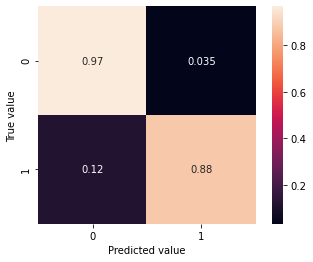

In [198]:
model_predictions = model.predict(X_test)

print('Unstable:', str(len(y_test[y_test == 0])),
      'Stable:',str(len(y_test[y_test == 1])))
print('Predicted Unstable:', str(len(model_predictions[model_predictions < .5])),
      'Predicted Stable:',str(len(model_predictions[model_predictions >= .5])))

model_predictions = model_predictions.round()
mat = confusion_matrix(y_test, model_predictions, normalize='true')
sns.heatmap(mat, square=True, annot=True, cbar=True)

plt.xlabel('Predicted value')
plt.ylabel('True value')
plt.show()

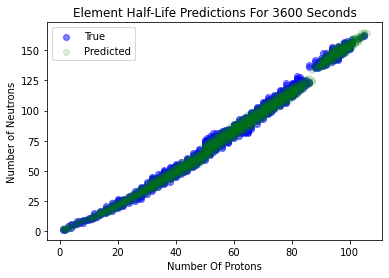

In [200]:
elements = generate_elements(1, int(X["Z"].max()), 1, int(X["N"].max()))
predictions = predict(model, elements)

protons = [element[0] for i,element in enumerate(elements) if predictions[i] >= .6]
neutrons = [element[1] for i,element in enumerate(elements) if predictions[i] >= .6]

stable_index = np.where(y)
plt.scatter(X.loc[stable_index, "Z"], X.loc[stable_index, "N"], alpha=0.5, label="True", color="Blue")
plt.scatter(protons, neutrons, alpha=0.15, label="Predicted", color="Green")

plt.xlabel('Number Of Protons')
plt.ylabel('Number of Neutrons')
plt.title(('Element Half-Life Predictions For ' + str(threshold) + " Seconds"))

plt.legend()
plt.show()

# Showing Final Results

In [201]:
def predict(model, element):
    protons, neutrons = element[0], element[1]
    X = pd.DataFrame({'Z':[protons], 'N':[neutrons]})
    X = add_features(X)
    input_layer = X.loc[0]
    result = model.predict(X)[0]
    return result[0]

def predict(model, elements):
    protons, neutrons = [element[0] for element in elements], [element[1] for element in elements]
    X = pd.DataFrame({'Z':protons, 'N':neutrons})
    X = add_features(X)
    result = model.predict(X).reshape(len(X))
    return list(result)

In [202]:
def generate_elements(min_protons, max_protons, min_neutrons, max_neutrons):
    elements = []
    for num_proton in range(min_protons, max_protons+1):
        for num_neutron in range(min_neutrons, max_neutrons+1):
            elements.append((num_proton, num_neutron))
    return elements

In [204]:
def generate_final_model(seconds_threshold):
    custom_unstable1 = generate_unstable_data(20, 60, 150, 170) #Data is for min_half-life
    custom_unstable2 = generate_unstable_data(1, 7, 40, 170) #Data is for min_half-life
    custom_unstable3 = generate_unstable_data(20, 120, 1, 7)

    df = load_df()
    df = pd.concat([custom_unstable1, custom_unstable2, custom_unstable3, df]).reset_index(drop=True) # Merge With Custom Unstable
    X, y = generate_X_y(df, seconds_threshold)

    model = best_tuner.hypermodel.build(best_tuner.get_best_hyperparameters()[0])#generate_model(X_train.shape[1])
    model.fit(X, y, epochs=4000, batch_size=30, verbose=0)
    
    return model

### Generating Threshold Models - 1 Minute To Run

In [205]:
mili_model = generate_final_model(.001)
print("Milisecond Model Done")
second_model = generate_final_model(1)
print("Second Model Done")
minute_model = generate_final_model(60)
print("Minute Model Done")
hour_model = generate_final_model(3600)
print("Hour Model Done")
day_model = generate_final_model(86400)
print("Day Model Done")
year_model = generate_final_model(3.154e+7)
print("Year Model Done")

Milisecond Model Done
Second Model Done
Minute Model Done
Hour Model Done
Day Model Done
Year Model Done


### Generating Final Results

In [587]:
max_protons, max_neutrons = 130, 200
min_protons, min_neutrons = 100, 120

elements = generate_elements(min_protons, max_protons, min_neutrons, max_neutrons)
        
        
mili, second = predict(mili_model, elements), predict(second_model, elements)
minute, hour = predict(minute_model, elements), predict(hour_model, elements)
day, year = predict(day_model, elements), predict(year_model, elements)

results = {}
for i, element in enumerate(elements):
    if round(year[i]): results[element] = (6, year[i])
    elif round(day[i]): results[element] = (5, day[i])
    elif round(hour[i]): results[element] = (4, hour[i])
    elif round(minute[i]): results[element] = (3, minute[i])
    elif round(second[i]): results[element] = (2, second[i])
    #elif round(mili[i]): results[element] = (1, mili[i])
    else: results[element] = (0, 1)

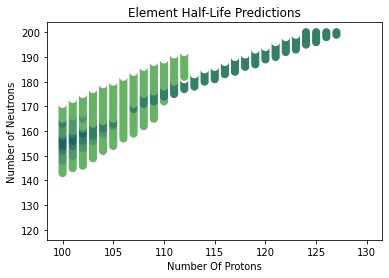

In [593]:
s = 50
colors = [(1,1,1), (.5,.8,.4), (.4,.7,.4), (.3,.6,.4), (.2,.5,.4), (.1,.4,.4), (0,.3,.4)]
labels = ["Unstable", "Half Life >= 1 MS", "Half Life >= 1 S", "Half Life >= 1 M", 
          "Half Life >= 1 H", "Half Life >= 1 D", "Half Life >= 1 Y"]

protons, neutrons = [i[0] for i in results.keys()], [i[1] for i in results.keys()]
label, color = [labels[i[0]] for i in results.values()], [colors[i[0]] for i in results.values()]
plt.scatter(protons, neutrons, s=s, c=color)

plt.xlabel('Number Of Protons')
plt.ylabel('Number of Neutrons')
plt.title('Element Half-Life Predictions')

plt.show()

# Regression Test

In [571]:
def get_magnitude(y):
        magnitudes = []
        for i in y:
            half_life = str(format(i,'e'))
            if half_life == 'nan': magnitudes.append(half_life)
            elif i == -1: magnitudes.append(32)
            elif i == 0: magnitudes.append(-23)
            else: magnitudes.append(float(half_life.split('e')[1]))

        return magnitudes

In [572]:
from keras.models import Sequential
from keras.layers import Dense, Activation

def generate_regression_model():

    input_units = X_train.shape[1]

    model = Sequential()
    model.add(Dense(input_units, input_dim=input_units))

    model.add(Dense(input_units, activation='relu'))
    model.add(Dense(input_units*2, activation='relu'))
    model.add(Dense(input_units*4, activation='relu'))
    model.add(Dense(input_units*4, activation='relu'))
    model.add(Dense(input_units, activation='relu'))

    model.add(Dense(1, activation='relu'))

    model.compile(loss='mean_squared_error', optimizer='adam')
    
    return model

In [576]:
from sklearn.model_selection import train_test_split

custom_unstable1 = generate_unstable_data(30, 50, 150, 170) #Data is for min_half-life
custom_unstable2 = generate_unstable_data(5, 9, 120, 170) #Data is for min_half-life
custom_unstable3 = generate_unstable_data(80, 120, 5, 15) ## Rerun with Changes Values

df = load_df()
#df = pd.concat([custom_unstable1, custom_unstable2, custom_unstable3, df]).reset_index(drop=True) # Merge With Custom Unstable

df["Half Life"] = list([convert_to_seconds(i) for i in df['Half Life'].values])
df = add_features(df)
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()

X, y = df.drop(['Half Life'], axis=1), pd.Series(get_magnitude(df['Half Life']))


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = generate_regression_model()
model.fit(X_train, y_train, epochs=1000, batch_size=30, verbose=1)

Epoch 1/1000
73/73 [==============================] - 1s 869us/step - loss: 100.1636
Epoch 2/1000
73/73 [==============================] - 0s 851us/step - loss: 98.1087
Epoch 3/1000
73/73 [==============================] - 0s 816us/step - loss: 97.9079
Epoch 4/1000
73/73 [==============================] - 0s 752us/step - loss: 97.3564
Epoch 5/1000
73/73 [==============================] - 0s 731us/step - loss: 96.9453
Epoch 6/1000
73/73 [==============================] - 0s 732us/step - loss: 96.4473
Epoch 7/1000
73/73 [==============================] - 0s 750us/step - loss: 95.9622
Epoch 8/1000
73/73 [==============================] - 0s 731us/step - loss: 95.2645
Epoch 9/1000
73/73 [==============================] - 0s 693us/step - loss: 94.8312
Epoch 10/1000
73/73 [==============================] - 0s 690us/step - loss: 93.8223
Epoch 11/1000
73/73 [==============================] - 0s 731us/step - loss: 93.1751
Epoch 12/1000
73/73 [==============================] - 0s 708us/step - lo

73/73 [==============================] - 0s 693us/step - loss: 71.0540
Epoch 98/1000
73/73 [==============================] - 0s 675us/step - loss: 67.0130
Epoch 99/1000
73/73 [==============================] - 0s 745us/step - loss: 69.1839
Epoch 100/1000
73/73 [==============================] - 0s 705us/step - loss: 67.4968
Epoch 101/1000
73/73 [==============================] - 0s 736us/step - loss: 65.5682
Epoch 102/1000
73/73 [==============================] - 0s 737us/step - loss: 65.5336
Epoch 103/1000
73/73 [==============================] - 0s 737us/step - loss: 63.7411
Epoch 104/1000
73/73 [==============================] - 0s 721us/step - loss: 63.1393
Epoch 105/1000
73/73 [==============================] - 0s 727us/step - loss: 65.0968
Epoch 106/1000
73/73 [==============================] - 0s 775us/step - loss: 62.7203
Epoch 107/1000
73/73 [==============================] - 0s 751us/step - loss: 61.3405
Epoch 108/1000
73/73 [==============================] - 0s 774us/step -

73/73 [==============================] - 0s 765us/step - loss: 55.1587
Epoch 193/1000
73/73 [==============================] - 0s 730us/step - loss: 54.4194
Epoch 194/1000
73/73 [==============================] - 0s 769us/step - loss: 54.1981
Epoch 195/1000
73/73 [==============================] - 0s 734us/step - loss: 59.9998
Epoch 196/1000
73/73 [==============================] - 0s 716us/step - loss: 54.5764
Epoch 197/1000
73/73 [==============================] - 0s 750us/step - loss: 52.8114
Epoch 198/1000
73/73 [==============================] - 0s 728us/step - loss: 52.6510
Epoch 199/1000
73/73 [==============================] - 0s 729us/step - loss: 54.5581
Epoch 200/1000
73/73 [==============================] - 0s 762us/step - loss: 53.2913
Epoch 201/1000
73/73 [==============================] - 0s 761us/step - loss: 54.4680
Epoch 202/1000
73/73 [==============================] - 0s 789us/step - loss: 52.9315
Epoch 203/1000
73/73 [==============================] - 0s 755us/step

73/73 [==============================] - 0s 892us/step - loss: 51.6316
Epoch 288/1000
73/73 [==============================] - 0s 883us/step - loss: 50.7480
Epoch 289/1000
73/73 [==============================] - 0s 813us/step - loss: 51.8403
Epoch 290/1000
73/73 [==============================] - 0s 832us/step - loss: 52.8126
Epoch 291/1000
73/73 [==============================] - 0s 807us/step - loss: 50.4836
Epoch 292/1000
73/73 [==============================] - 0s 849us/step - loss: 52.5402
Epoch 293/1000
73/73 [==============================] - 0s 1ms/step - loss: 54.5431
Epoch 294/1000
73/73 [==============================] - 0s 1ms/step - loss: 51.6853
Epoch 295/1000
73/73 [==============================] - 0s 970us/step - loss: 51.4451
Epoch 296/1000
73/73 [==============================] - 0s 852us/step - loss: 51.3345
Epoch 297/1000
73/73 [==============================] - 0s 860us/step - loss: 53.8612
Epoch 298/1000
73/73 [==============================] - 0s 835us/step - l

73/73 [==============================] - 0s 863us/step - loss: 54.3432
Epoch 383/1000
73/73 [==============================] - 0s 870us/step - loss: 52.6920
Epoch 384/1000
73/73 [==============================] - 0s 833us/step - loss: 54.7243
Epoch 385/1000
73/73 [==============================] - 0s 789us/step - loss: 51.8799
Epoch 386/1000
73/73 [==============================] - 0s 815us/step - loss: 52.0897
Epoch 387/1000
73/73 [==============================] - 0s 869us/step - loss: 51.9698
Epoch 388/1000
73/73 [==============================] - 0s 881us/step - loss: 51.4756
Epoch 389/1000
73/73 [==============================] - 0s 830us/step - loss: 51.7909
Epoch 390/1000
73/73 [==============================] - 0s 845us/step - loss: 51.9589
Epoch 391/1000
73/73 [==============================] - 0s 856us/step - loss: 52.4930
Epoch 392/1000
73/73 [==============================] - 0s 838us/step - loss: 50.5396
Epoch 393/1000
73/73 [==============================] - 0s 846us/step

73/73 [==============================] - 0s 689us/step - loss: 50.3748
Epoch 478/1000
73/73 [==============================] - 0s 707us/step - loss: 53.0602
Epoch 479/1000
73/73 [==============================] - 0s 684us/step - loss: 53.5926
Epoch 480/1000
73/73 [==============================] - 0s 679us/step - loss: 51.0949
Epoch 481/1000
73/73 [==============================] - 0s 716us/step - loss: 51.6397
Epoch 482/1000
73/73 [==============================] - 0s 673us/step - loss: 51.0191
Epoch 483/1000
73/73 [==============================] - 0s 683us/step - loss: 51.6565
Epoch 484/1000
73/73 [==============================] - 0s 687us/step - loss: 51.5150
Epoch 485/1000
73/73 [==============================] - 0s 685us/step - loss: 50.5133
Epoch 486/1000
73/73 [==============================] - 0s 679us/step - loss: 53.0768
Epoch 487/1000
73/73 [==============================] - 0s 689us/step - loss: 50.3509
Epoch 488/1000
73/73 [==============================] - 0s 686us/step

73/73 [==============================] - 0s 746us/step - loss: 51.3307
Epoch 573/1000
73/73 [==============================] - 0s 761us/step - loss: 51.2778
Epoch 574/1000
73/73 [==============================] - 0s 738us/step - loss: 50.8677
Epoch 575/1000
73/73 [==============================] - 0s 750us/step - loss: 52.0066
Epoch 576/1000
73/73 [==============================] - 0s 782us/step - loss: 50.4547
Epoch 577/1000
73/73 [==============================] - 0s 786us/step - loss: 52.0320
Epoch 578/1000
73/73 [==============================] - 0s 783us/step - loss: 49.9624
Epoch 579/1000
73/73 [==============================] - 0s 748us/step - loss: 58.0503
Epoch 580/1000
73/73 [==============================] - 0s 755us/step - loss: 51.1516
Epoch 581/1000
73/73 [==============================] - 0s 773us/step - loss: 49.8711
Epoch 582/1000
73/73 [==============================] - 0s 742us/step - loss: 50.6995
Epoch 583/1000
73/73 [==============================] - 0s 775us/step

73/73 [==============================] - 0s 740us/step - loss: 50.0160
Epoch 668/1000
73/73 [==============================] - 0s 774us/step - loss: 49.9670
Epoch 669/1000
73/73 [==============================] - 0s 726us/step - loss: 50.0576
Epoch 670/1000
73/73 [==============================] - 0s 716us/step - loss: 50.6858
Epoch 671/1000
73/73 [==============================] - 0s 711us/step - loss: 52.1908
Epoch 672/1000
73/73 [==============================] - 0s 725us/step - loss: 50.3190
Epoch 673/1000
73/73 [==============================] - 0s 734us/step - loss: 50.0160
Epoch 674/1000
73/73 [==============================] - 0s 760us/step - loss: 49.9947
Epoch 675/1000
73/73 [==============================] - 0s 777us/step - loss: 50.8717
Epoch 676/1000
73/73 [==============================] - 0s 723us/step - loss: 50.9822
Epoch 677/1000
73/73 [==============================] - 0s 753us/step - loss: 51.1382
Epoch 678/1000
73/73 [==============================] - 0s 716us/step

73/73 [==============================] - 0s 728us/step - loss: 50.3245
Epoch 763/1000
73/73 [==============================] - 0s 750us/step - loss: 49.2573
Epoch 764/1000
73/73 [==============================] - 0s 824us/step - loss: 49.5580
Epoch 765/1000
73/73 [==============================] - 0s 750us/step - loss: 50.2535
Epoch 766/1000
73/73 [==============================] - 0s 695us/step - loss: 50.3784
Epoch 767/1000
73/73 [==============================] - 0s 707us/step - loss: 50.6496
Epoch 768/1000
73/73 [==============================] - 0s 711us/step - loss: 49.5604
Epoch 769/1000
73/73 [==============================] - 0s 983us/step - loss: 49.7255
Epoch 770/1000
73/73 [==============================] - 0s 2ms/step - loss: 49.9626
Epoch 771/1000
73/73 [==============================] - 0s 768us/step - loss: 49.6313
Epoch 772/1000
73/73 [==============================] - 0s 722us/step - loss: 51.4065
Epoch 773/1000
73/73 [==============================] - 0s 737us/step -

73/73 [==============================] - 0s 739us/step - loss: 50.5669
Epoch 858/1000
73/73 [==============================] - 0s 756us/step - loss: 50.0775
Epoch 859/1000
73/73 [==============================] - 0s 731us/step - loss: 50.4630
Epoch 860/1000
73/73 [==============================] - 0s 757us/step - loss: 50.7941
Epoch 861/1000
73/73 [==============================] - 0s 736us/step - loss: 49.5648
Epoch 862/1000
73/73 [==============================] - 0s 736us/step - loss: 50.4180
Epoch 863/1000
73/73 [==============================] - 0s 781us/step - loss: 51.2163
Epoch 864/1000
73/73 [==============================] - 0s 760us/step - loss: 50.0899
Epoch 865/1000
73/73 [==============================] - 0s 800us/step - loss: 51.9625
Epoch 866/1000
73/73 [==============================] - 0s 754us/step - loss: 51.7784
Epoch 867/1000
73/73 [==============================] - 0s 859us/step - loss: 49.7833
Epoch 868/1000
73/73 [==============================] - 0s 785us/step

73/73 [==============================] - 0s 812us/step - loss: 49.4663
Epoch 953/1000
73/73 [==============================] - 0s 772us/step - loss: 50.9075
Epoch 954/1000
73/73 [==============================] - 0s 783us/step - loss: 51.8351
Epoch 955/1000
73/73 [==============================] - 0s 772us/step - loss: 49.7263
Epoch 956/1000
73/73 [==============================] - 0s 791us/step - loss: 49.5398
Epoch 957/1000
73/73 [==============================] - 0s 762us/step - loss: 52.3293
Epoch 958/1000
73/73 [==============================] - 0s 820us/step - loss: 52.4455
Epoch 959/1000
73/73 [==============================] - 0s 822us/step - loss: 48.8688
Epoch 960/1000
73/73 [==============================] - 0s 864us/step - loss: 49.6354
Epoch 961/1000
73/73 [==============================] - 0s 820us/step - loss: 49.0195
Epoch 962/1000
73/73 [==============================] - 0s 802us/step - loss: 50.3995
Epoch 963/1000
73/73 [==============================] - 0s 798us/step

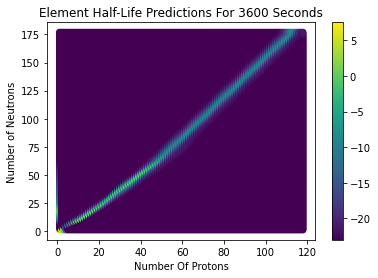

In [577]:
### FIX UNSTABLE TARGET VALUE -- CHANGE FROM 00 to -23 or Somtin

elements = generate_elements(1, int(X["Z"].max()), 1, int(X["N"].max()))
predictions = [i-23 for i in predict(model, elements)]

protons = [element[0] for element in elements]
neutrons = [element[1] for element in elements]


plt.scatter(protons, neutrons, alpha=1, label="Predicted", c=predictions, cmap='viridis')

plt.xlabel('Number Of Protons')
plt.ylabel('Number of Neutrons')
plt.title(('Element Half-Life Predictions For ' + str(threshold) + " Seconds"))

plt.colorbar()
plt.show()